## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [ ]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 31.8 MB/s 
     |████████████████████████████████| 212 kB 75.5 MB/s 


In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
#This function will return accuracy, validation accuraacy, loss and validation loss
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

  #This function will return the value of confusion matrix and plot it   
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.2


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [ ]:
dataset= nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
train=dataset['train']
val=dataset['validation']
test=dataset['test']

In [ ]:
def get_tweet(data):
  tweets=[x['text'] for x in data]   #To extract tweets under 'text' column  from a dataset
  labels=[x['label'] for x in data]   #To extract labels of those tweets under 'label' column  from a dataset

  return tweets,labels

In [ ]:
tweets, labels=get_tweet(train) # Getting tweets and labels for training dataset

In [ ]:

tweets[1],labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
# Tokenization is the process of converting words to numbers because to train a ml model we need numbers
# A simple approach tokenizer uses is to create a corpus of all the words that exist in the dataset and assign a token to them
# We can give a parameter to token frequently used wordss and leave less frequent ones
tokenizer=Tokenizer(num_words=10000,oov_token='<UNK>') # tokenizing most frequent 10000 words and the words which are not present in that are given a common token 'UNK'
tokenizer.fit_on_texts(tweets)


In [ ]:
tokenizer.texts_to_sequences([tweets[0]]) # We can see what tokenizer is doing

[[2, 139, 3, 679]]

In [ ]:

tweets[0]

'i didnt feel humiliated'

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

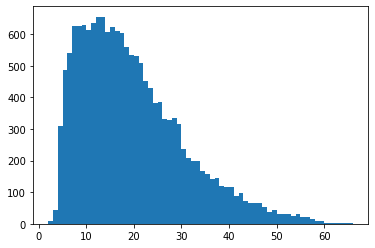

In [ ]:
#ML model needs a fixed shape as input but tweets may be of different lengths so we nedd to truncate and padd
lengths=[len(t.split(' ')) for t in tweets]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

# This histogram shows the distributions of length of words

In [ ]:
maxlen=50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Defining a function which takes tweets as input and returns padded sequences
def get_sequences(tokenizer,tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences,truncating='post',padding='post',maxlen=maxlen) #post means at the end of the sequences
  return padded

In [ ]:
padded_train_seq=get_sequences(tokenizer,tweets)

In [ ]:
padded_train_seq[0] # we can check that a tweet has become an array of 50 dimensions

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [ ]:
classes=set(labels) #creating a set for multiclasses which include the printed classes
print(classes)

{'love', 'surprise', 'joy', 'anger', 'fear', 'sadness'}


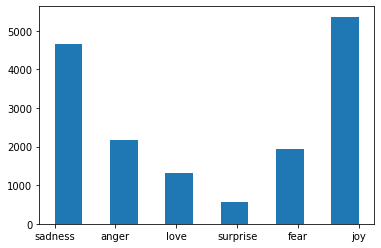

In [ ]:
#Checking number of examples in every class
plt.hist(labels,bins=11)
plt.show()
#class imblance problem is present but our model will work fine

In [ ]:
class_to_index=dict((c,i) for i,c in enumerate(classes)) #To assign numbers to different classes
index_to_class=dict((v,k) for k,v in class_to_index.items()) # The opposite of that

In [ ]:
class_to_index

{'anger': 3, 'fear': 4, 'joy': 2, 'love': 0, 'sadness': 5, 'surprise': 1}

In [ ]:
names_to_ids=lambda labels: np.array([class_to_index.get(x) for x in labels])

In [ ]:
train_labels=names_to_ids(labels)
print(train_labels[0])

# Now we have our training labels, we can create the model

5


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000,16,input_length=maxlen), #Input dimension 10000, output is 16, or we can say each word is represented by 16 dimensional vector
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)), #Using LSTM in Bidirectional means that the context in lstm layer can go both sides left to right or both
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)), # Next layer
    tf.keras.layers.Dense(6,activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy', # Because the values are not one hot encoded we are using sparse categorical encoding
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [ ]:
#preparing a validation set
val_tweets,val_labels=get_tweet(val)
val_seq=get_sequences(tokenizer,val_tweets)
val_labels=names_to_ids(val_labels)

In [ ]:
val_tweets[0],val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 5)

In [ ]:
h=model.fit(
    padded_train_seq,train_labels,
    validation_data=(val_seq,val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_acuracy',patience=2)
    ]

)

Epoch 1/20
500/500 [==============================] - ETA: 0s - loss: 1.2531 - accuracy: 0.5122

500/500 [==============================] - 16s 15ms/step - loss: 1.2531 - accuracy: 0.5122 - val_loss: 0.8181 - val_accuracy: 0.7150
Epoch 2/20
496/500 [============================>.] - ETA: 0s - loss: 0.5343 - accuracy: 0.8128

500/500 [==============================] - 6s 12ms/step - loss: 0.5342 - accuracy: 0.8127 - val_loss: 0.5796 - val_accuracy: 0.7940
Epoch 3/20
499/500 [============================>.] - ETA: 0s - loss: 0.3327 - accuracy: 0.8868

500/500 [==============================] - 6s 12ms/step - loss: 0.3330 - accuracy: 0.8867 - val_loss: 0.4847 - val_accuracy: 0.8345
Epoch 4/20
498/500 [============================>.] - ETA: 0s - loss: 0.2328 - accuracy: 0.9184

500/500 [==============================] - 7s 13ms/step - loss: 0.2327 - accuracy: 0.9185 - val_loss: 0.4205 - val_accuracy: 0.8725
Epoch 5/20
497/500 [============================>.] - ETA: 0s - loss: 0.1556 - accuracy: 0.9506

500/500 [==============================] - 6s 12ms/step - loss: 0.1557 - accuracy: 0.9504 - val_loss: 0.3865 - val_accuracy: 0.8825
Epoch 6/20
497/500 [============================>.] - ETA: 0s - loss: 0.1159 - accuracy: 0.9645

500/500 [==============================] - 6s 12ms/step - loss: 0.1157 - accuracy: 0.9646 - val_loss: 0.4503 - val_accuracy: 0.8820
Epoch 7/20
500/500 [==============================] - ETA: 0s - loss: 0.0947 - accuracy: 0.9702

500/500 [==============================] - 6s 12ms/step - loss: 0.0947 - accuracy: 0.9702 - val_loss: 0.4418 - val_accuracy: 0.8800
Epoch 8/20
498/500 [============================>.] - ETA: 0s - loss: 0.0794 - accuracy: 0.9748

500/500 [==============================] - 6s 12ms/step - loss: 0.0797 - accuracy: 0.9747 - val_loss: 0.4427 - val_accuracy: 0.8890
Epoch 9/20
499/500 [============================>.] - ETA: 0s - loss: 0.0674 - accuracy: 0.9790

500/500 [==============================] - 6s 12ms/step - loss: 0.0674 - accuracy: 0.9789 - val_loss: 0.4065 - val_accuracy: 0.8930
Epoch 10/20
499/500 [============================>.] - ETA: 0s - loss: 0.0560 - accuracy: 0.9833

500/500 [==============================] - 6s 12ms/step - loss: 0.0559 - accuracy: 0.9833 - val_loss: 0.4229 - val_accuracy: 0.8945
Epoch 11/20
499/500 [============================>.] - ETA: 0s - loss: 0.0530 - accuracy: 0.9835

500/500 [==============================] - 6s 12ms/step - loss: 0.0529 - accuracy: 0.9835 - val_loss: 0.4054 - val_accuracy: 0.8975
Epoch 12/20
497/500 [============================>.] - ETA: 0s - loss: 0.0494 - accuracy: 0.9853

500/500 [==============================] - 6s 12ms/step - loss: 0.0491 - accuracy: 0.9854 - val_loss: 0.4198 - val_accuracy: 0.8970
Epoch 13/20
500/500 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.9870

500/500 [==============================] - 6s 12ms/step - loss: 0.0422 - accuracy: 0.9870 - val_loss: 0.4145 - val_accuracy: 0.8930
Epoch 14/20
499/500 [============================>.] - ETA: 0s - loss: 0.0475 - accuracy: 0.9854

500/500 [==============================] - 6s 12ms/step - loss: 0.0475 - accuracy: 0.9854 - val_loss: 0.3718 - val_accuracy: 0.9015
Epoch 15/20
499/500 [============================>.] - ETA: 0s - loss: 0.0308 - accuracy: 0.9899

500/500 [==============================] - 6s 13ms/step - loss: 0.0307 - accuracy: 0.9899 - val_loss: 0.4058 - val_accuracy: 0.8990
Epoch 16/20
498/500 [============================>.] - ETA: 0s - loss: 0.0294 - accuracy: 0.9903

500/500 [==============================] - 6s 12ms/step - loss: 0.0294 - accuracy: 0.9904 - val_loss: 0.4155 - val_accuracy: 0.8960
Epoch 17/20
498/500 [============================>.] - ETA: 0s - loss: 0.0313 - accuracy: 0.9890

500/500 [==============================] - 6s 12ms/step - loss: 0.0312 - accuracy: 0.9890 - val_loss: 0.4094 - val_accuracy: 0.9085
Epoch 18/20
497/500 [============================>.] - ETA: 0s - loss: 0.0326 - accuracy: 0.9889

500/500 [==============================] - 6s 12ms/step - loss: 0.0326 - accuracy: 0.9890 - val_loss: 0.4484 - val_accuracy: 0.8920
Epoch 19/20
498/500 [============================>.] - ETA: 0s - loss: 0.0269 - accuracy: 0.9907

500/500 [==============================] - 6s 12ms/step - loss: 0.0268 - accuracy: 0.9908 - val_loss: 0.4415 - val_accuracy: 0.8980
Epoch 20/20
498/500 [============================>.] - ETA: 0s - loss: 0.0332 - accuracy: 0.9886

500/500 [==============================] - 7s 13ms/step - loss: 0.0335 - accuracy: 0.9886 - val_loss: 0.4951 - val_accuracy: 0.8975


## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

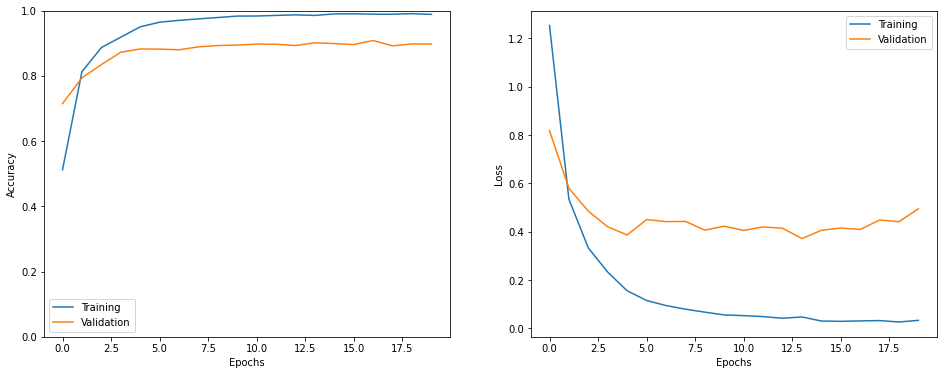

In [ ]:
#first simply look at the training history
show_history(h)

In [ ]:
# prepare a test set
test_tweets,test_labels=get_tweet(test)
test_seq=get_sequences(tokenizer,test_tweets)
test_labels=names_to_ids(test_labels)

In [ ]:
_=model.evaluate(test_seq,test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.5246 - accuracy: 0.8920


In [ ]:
#Randomly manually testing the model
i=random.randint(0,len(test_labels)-1)
print('Sentence:', test_tweets[i])
print('Emotion: ',index_to_class[test_labels[i]])

p=model.predict(np.expand_dims(test_seq[i],axis=0))[0]
predicted_class=index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion: ',predicted_class)

Sentence: i know that i have it nowhere near as worse as my brethren overseas but right now i feel like im being physically emotionally and spiritually assaulted
Emotion:  fear
Predicted Emotion:  fear


In [ ]:
preds = np.argmax(model.predict(test_seq),axis=1)

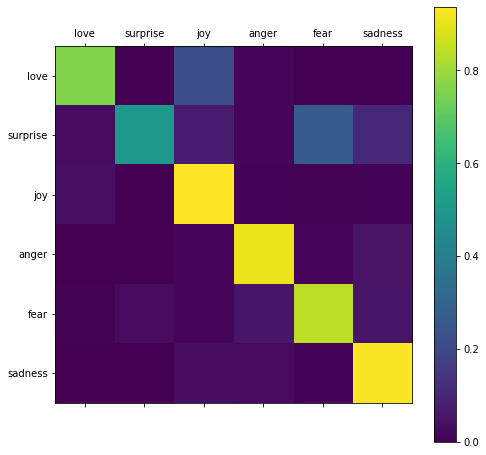

In [ ]:
show_confusion_matrix(test_labels,preds,list(classes))
# There is some confusion between joy and love and surprise and fear and its possible that if we didnt have class imbalance (lots more examples)
#Then these misclassification has been less